In [1]:
# ********************************************************
# 1. IMPORTS
# ********************************************************

In [9]:
from __future__ import print_function
import skimage.io as skio
import skimage as sk
import numpy as np
import cv2
import imageio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import SimilarityTransform, warp
from scipy import sparse, misc, signal
from scipy.sparse import bsr_matrix

In [10]:
# ********************************************************
# 1. LOAD IMAGES 
# ********************************************************

(249, 357, 3)


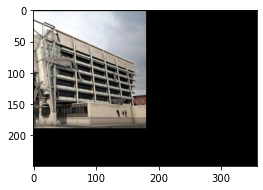

In [11]:
source = "source_01_newsource.png"
source = skio.imread(source)
source= sk.img_as_float(source)

print(source.shape)

plt.figure(figsize = (4,4))
plt.imshow(source)

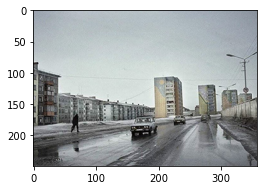

In [12]:
target = "target_01.jpg"
target = skio.imread(target)
target = sk.img_as_float(target)

plt.figure(figsize = (4,4))
plt.imshow(target)

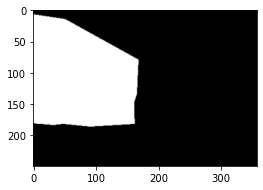

In [13]:
mask = "target_01_mask.png"
mask = skio.imread(mask)
mask = sk.img_as_float(mask)

plt.figure(figsize = (4,4))
plt.imshow(mask)

In [14]:
print(f'source = {source.shape}')
print(f'target = {target.shape}')
print(f'mask = {mask.shape}')

source = (249, 357, 3)
target = (249, 357, 3)
mask = (249, 357, 3)


In [15]:
# ********************************************************
# 2. COUNT NUMBER OF PIXELS
# ********************************************************

In [16]:
total_pixel_count = 0
mask_pixel_count = 0

for elem in mask:
    for inner in elem:
        total_pixel_count += 1
        if inner[0] != 0.0:
            mask_pixel_count += 1

print(f'total pixel count = {total_pixel_count}')
print(f'mask pixel count  = {mask_pixel_count}')
print(f'prelim equation count  = {mask_pixel_count*4}')

total pixel count = 88893
mask pixel count  = 24752
prelim equation count  = 99008


In [17]:
# ********************************************************
# 2.5 DEFINE NON-ZERO INDICES OF MASK
# ********************************************************

In [18]:
# 1. Split mask into seperate 1d r,g,b channels
b_mask, g_mask, r_mask = cv2.split(mask)

# 2. Compute the indices that are non-zero, aka the area to mask
mask_nonzero = np.transpose(np.nonzero(b_mask))

In [19]:
# ********************************************************
# 3. DEFINE DIRECT PASTE FUNCTION
# ********************************************************

In [20]:
# - To be used after "v" is solved
# - To paste new source image "v" ontop of original target image

def image_paste(source , mask, target):
    lev_1 = -1
    lev_2 = -1
    lev_3 = -1

    depth, height, width = source.shape

    for dim_1 in mask:
        if lev_1 == depth-1:
                lev_1 = -1
        lev_1 += 1

        for dim_2 in dim_1:
            if lev_2 == height-1:
                lev_2 = -1
            lev_2 += 1

            for dim_3 in dim_2:
                if lev_3 == width-1:
                    lev_3 = -1
                lev_3 += 1

                if dim_3 == 1:
                    target[lev_1][lev_2][lev_3] =  source[lev_1][lev_2][lev_3]
    return target

In [21]:
# ********************************************************
# 4. SPLIT SOURCE IMAGE INTO 3 CHANNELS
# ********************************************************

In [22]:
b_sor, g_sor, r_sor = cv2.split(source)

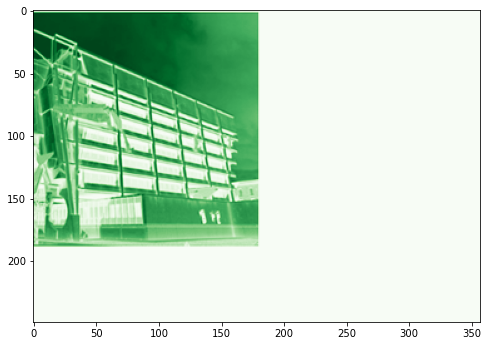

In [46]:
plt.figure(figsize = (8,8))
plt.imshow(g_sor, cmap = 'Greens')

In [29]:
# ********************************************************
# 5. SPLIT TARGET IMAGE INTO 3 CHANNELS
# ********************************************************

In [30]:
b_tar, g_tar, r_tar = cv2.split(target)

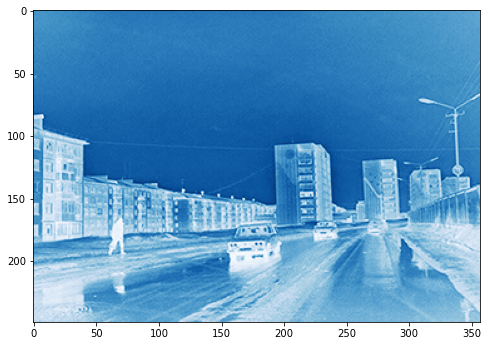

In [49]:
plt.figure(figsize = (8,8))
plt.imshow(b_tar, cmap = "Blues")

In [20]:
# ********************************************************
# 5. DEFINE GRADIENT DOMAIN PROCESSING FUNCTION
# ********************************************************

In [21]:
def GradientDomainProcessing(img, targ_img):
   
    # 1. Define entire mask width & height
    #    - mask dimensions are same as full image dimensions
    imh = mask.shape[0]
    imw = mask.shape[1]
    
    # 2. Determine pixel count of entire image
    #    ** I'm using entire pixel count as I reduced all image sizes by 2/3 in order
    #       to prevent runtime crash.  Because my code can now be applied to entire image
    #       I decided not to use "mask pixel count".  See step "2. COUNT NUMBER OF PIXELS"
    # total_pixel_count = total_pixel_count

    
    # 3. Define Number of Equations & Assign to 1D zeros Array
    #    - As image size reduced by 2/3, I can assign equation count = total_pixel_count * 4
    #      without crashing runtime
    equation_count = mask_pixel_count*4
    b = np.zeros(shape = (equation_count, 1))
    
    
    # 4. Create Sparse Lil_Matrix
    A_zeros = np.zeros(shape = (equation_count, total_pixel_count), dtype = 'int64')
    A = sparse.lil_matrix(A_zeros)


    # 5. Create "im2var" Matrix
    # - maps each pixel to variable number
    # im2var = np.arange(imh * imw).reshape((imh, imw)).astype(int)
    im2var = np.arange(imh * imw).reshape((imh, imw)).astype(int)
    
    # 6. Loop through source image and define values to A sparse Matrix &
    #    the "b" 1d array of "known values"
    
    e = 0
    
    for elem in mask_nonzero:  
        
        y = elem[0]
        x = elem[1]

        # X+1 Check
        if mask[y][x+1][0] == 1:
            A[e, im2var[y, x + 1]] = 1
            A[e, im2var[y, x]] -= 1           
            b[e] = img[y, x + 1] - img[y, x]                    
            e +=1 
        if mask[y][x+1][0] == 0:
            A[e, im2var[y, x]] = 1   
            b[e] = targ_img[y, x+1] - (img[y, x + 1] - img[y, x])                 
            e +=1   

        # X-1 Check
        if mask[y][x-1][0] == 1:
            A[e, im2var[y, x - 1]] = 1
            A[e, im2var[y, x]] -= 1
            b[e] = img[y, x - 1] - img[y, x]
            e +=1 
        if mask[y][x-1][0] == 0:
            #A[e, im2var[y, x]] = 1 
            b[e] = targ_img[y, x-1] - (img[y, x - 1] - img[y, x])
            e +=1 

        # Y+1 Check
        if mask[y+1][x][0] == 1:
            A[e, im2var[y+1, x]] = 1
            A[e, im2var[y, x]] -= 1
            b[e] = img[y+1, x] - img[y, x]
            e +=1                  
        if mask[y+1][x][0] == 0:
            A[e, im2var[y, x]] = 1 
            b[e] = targ_img[y+1, x] - (img[y+1, x] - img[y, x])
            e +=1 

        # Y-1 Check
        if mask[y-1][x][0] == 1:
            A[e, im2var[y-1, x]] = 1
            A[e, im2var[y, x]] -= 1
            b[e] = img[y-1, x] - img[y, x]
            e +=1 
        if mask[y-1][x][0] == 0:
            A[e, im2var[y, x]] = 1 
            b[e] = targ_img[y-1, x] - (img[y-1, x] - img[y, x])
            e +=1 

    
    # 7. Solve for "v" using Linalg.Lsqr per instructions
    v = sparse.linalg.lsqr(A, b)[0]    

    
    # 8. ReShape "v" back into original dimensions
    v = np.reshape(v, (imh, imw))
    
    return v

In [22]:
# ********************************************************
# 6. SOLVE "V" FOR EACH CHANNEL & DISPLAY RESULTS
# ********************************************************

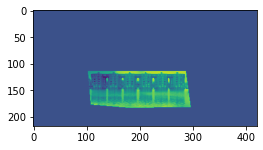

In [23]:
r_new = GradientDomainProcessing(r_sor, r_tar)

plt.figure(figsize = (4,4)) # resize image as required
plt.imshow(r_new)

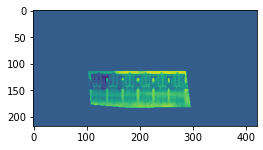

In [24]:
g_new = GradientDomainProcessing(g_sor, g_tar)

plt.figure(figsize = (4,4)) # resize image as required
plt.imshow(g_new)

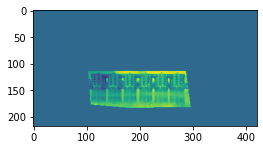

In [25]:
b_new = GradientDomainProcessing(b_sor, b_tar)

plt.figure(figsize = (4,4)) # resize image as required
plt.imshow(b_new)

In [26]:
# ********************************************************
# 7. STACK CHANNELS INTO ONE IMAGE & DISPLAY
# ********************************************************

In [27]:
rgb_stack_1 = np.dstack((b_new, g_new, r_new))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


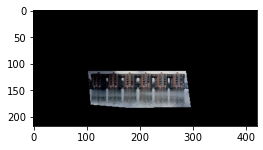

In [28]:
plt.figure(figsize = (4,4)) # resize image as required
plt.imshow(rgb_stack_1)

In [29]:
# ********************************************************
# 7. PRINT RAW PASTE W/O POISSON BLENDING FOR COMPARISON
# ********************************************************

In [30]:
raw_paste = image_paste(source , mask, target)

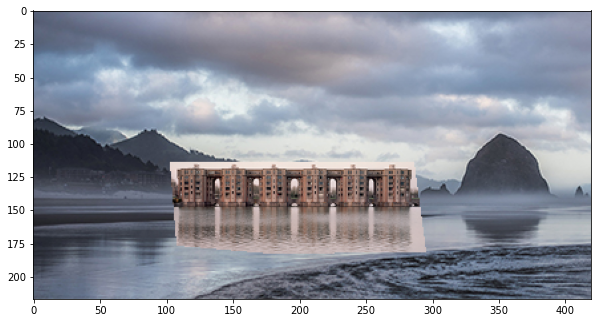

In [31]:
plt.figure(figsize = (10,10
                     )) # resize image as required
plt.imshow(raw_paste)

In [32]:
# ********************************************************
# 6. PASTE NEW SOURCE ONTO ORIGINAL TARGET IMAGE & DISPLAY
# ********************************************************

In [33]:
target_1 = image_paste(rgb_stack_1 , mask, target)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


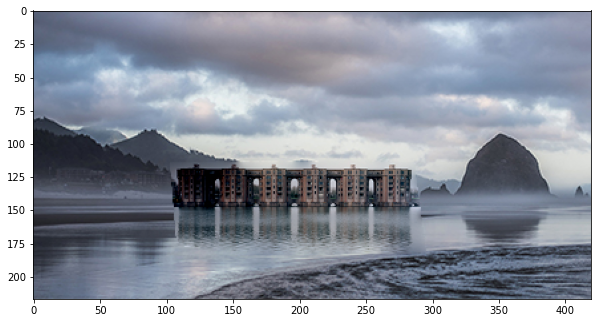

In [34]:
plt.figure(figsize = (10,10)) # resize image as required
plt.imshow(target_1)